Distribuție train:
quality_group
medium    2932
high       833
low        153
Name: count, dtype: int64

Distribuție test:
quality_group
medium    723
high      227
low        30
Name: count, dtype: int64

Distribuție după ADASYN:
Counter({'low': 2945, 'medium': 2932, 'high': 833})

Acuratețea modelului RidgeClassifier cu ADASYN: 57.55%

Classification Report:
              precision    recall  f1-score   support

        high       0.74      0.09      0.16       227
         low       0.09      0.67      0.15        30
      medium       0.73      0.72      0.73       723

    accuracy                           0.58       980
   macro avg       0.52      0.49      0.35       980
weighted avg       0.71      0.58      0.58       980



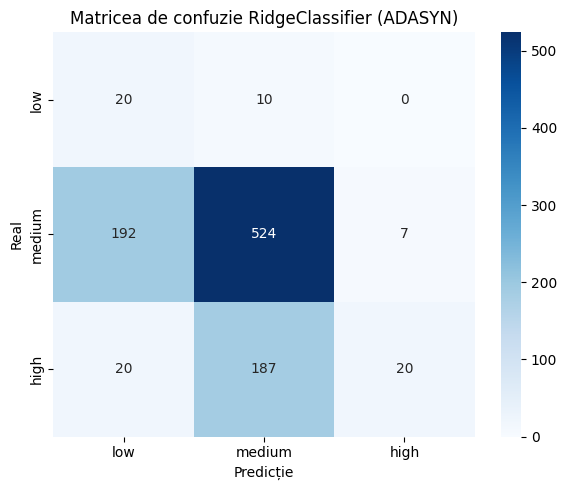

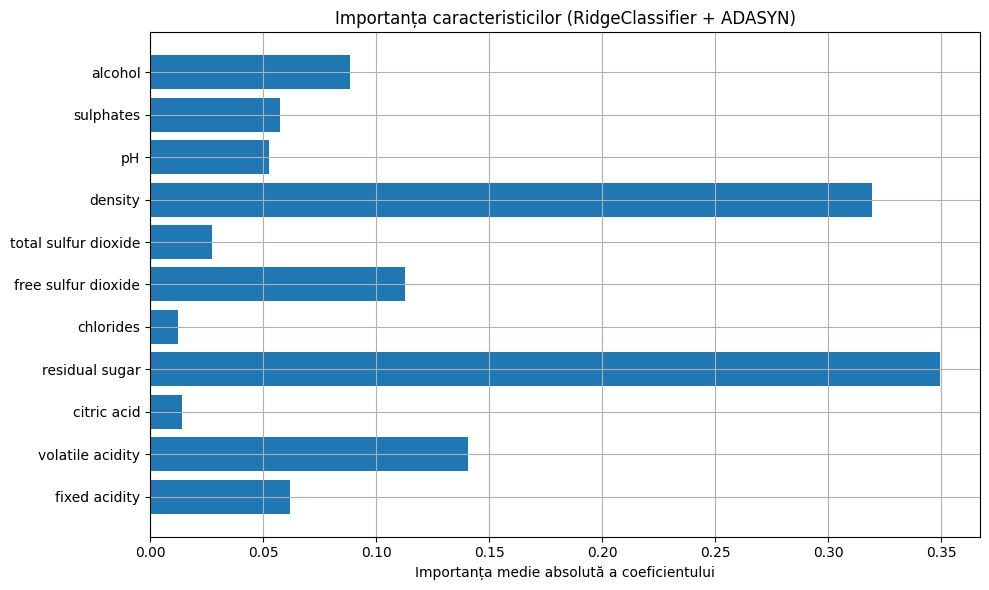

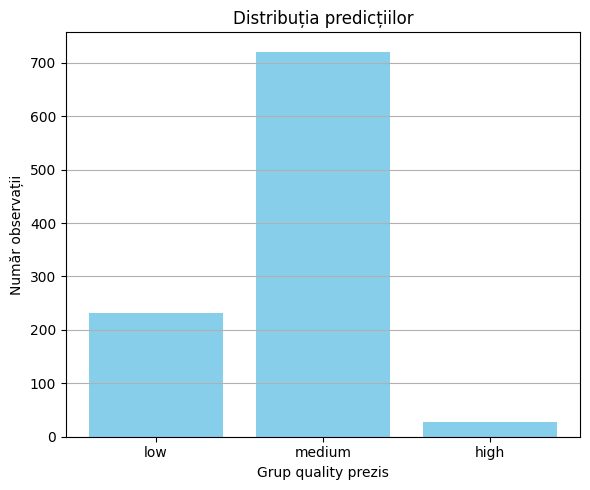

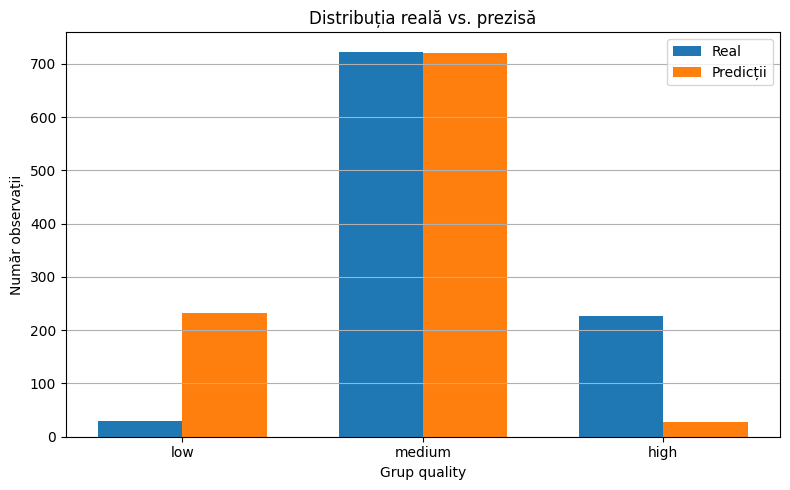

Ordinea claselor: ['high' 'low' 'medium']

Variabile care cresc probabilitatea 'high':
             Feature  Coefficient
      residual sugar     0.259176
             alcohol     0.132493
                  pH     0.078994
           sulphates     0.066451
 free sulfur dioxide     0.057834
       fixed acidity     0.055012
total sulfur dioxide     0.002998
           chlorides     0.001630
         citric acid    -0.021396
    volatile acidity    -0.048719


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections
from imblearn.over_sampling import ADASYN

# 1. Citire date
train_df = pd.read_csv("dataset/wine_train.csv", sep=';', quotechar='"')
test_df = pd.read_csv("dataset/wine_test.csv", sep=';', quotechar='"')

# 2. Grupare quality
def map_quality(q):
    if q in [3, 4]:
        return "low"
    elif q in [5, 6]:
        return "medium"
    else:
        return "high"

train_df["quality_group"] = train_df["quality"].apply(map_quality)
test_df["quality_group"] = test_df["quality"].apply(map_quality)

print("Distribuție train:")
print(train_df["quality_group"].value_counts())
print("\nDistribuție test:")
print(test_df["quality_group"].value_counts())

# 3. Separare X și y
X_train = train_df.drop(["quality", "quality_group"], axis=1)
y_train = train_df["quality_group"]

X_test = test_df.drop(["quality", "quality_group"], axis=1)
y_test = test_df["quality_group"]

# 4. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. ADASYN Over-sampling
adasyn = ADASYN(random_state=42, sampling_strategy="minority", n_neighbors=10)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Verificăm distribuția după resampling
print("\nDistribuție după ADASYN:")
print(collections.Counter(y_train_resampled))

# 6. Antrenare model
model = RidgeClassifier(alpha=10.0, fit_intercept=True, solver='auto', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# 7. Predictii
y_pred = model.predict(X_test_scaled)

# 8. Evaluare
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier cu ADASYN: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. Matrice confuzie
cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"]
)
plt.xlabel("Predicție")
plt.ylabel("Real")
plt.title("Matricea de confuzie RidgeClassifier (ADASYN)")
plt.tight_layout()
plt.show()

# 10. Analiză coeficienți
mean_abs_coefs = np.mean(np.abs(model.coef_), axis=0)
feature_names = X_train.columns

plt.figure(figsize=(10,6))
plt.barh(feature_names, mean_abs_coefs)
plt.xlabel("Importanța medie absolută a coeficientului")
plt.title("Importanța caracteristicilor (RidgeClassifier + ADASYN)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Distribuția predicțiilor
pred_counts = collections.Counter(y_pred)
labels = ["low", "medium", "high"]
counts = [pred_counts.get(label, 0) for label in labels]

plt.figure(figsize=(6,5))
plt.bar(labels, counts, color="skyblue")
plt.xlabel("Grup quality prezis")
plt.ylabel("Număr observații")
plt.title("Distribuția predicțiilor")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# 12. Comparativ real vs prezis
real_counts = collections.Counter(y_test)
real_counts_values = [real_counts.get(label, 0) for label in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, real_counts_values, width, label="Real")
plt.bar(x + width/2, counts, width, label="Predicții")
plt.xticks(x, labels)
plt.xlabel("Grup quality")
plt.ylabel("Număr observații")
plt.title("Distribuția reală vs. prezisă")
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# 13. Top coeficienți clasa 'high'
print("Ordinea claselor:", model.classes_)
index_high = list(model.classes_).index("high")
coefs_high = model.coef_[index_high]
df_high = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": coefs_high
}).sort_values(by="Coefficient", ascending=False)
print("\nVariabile care cresc probabilitatea 'high':")
print(df_high.head(10).to_string(index=False))
